In [ ]:
"""
不同SPEI数据和high-SPEI的不同grid scall对比
"""

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import multiprocessing
import os
import time
import gloce as gc
from osgeo import gdal
from osgeo import gdalconst
from mpl_toolkits.basemap import Basemap
from glob import glob
from math import ceil
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
#return im_data, im_width, im_height, im_geotrans, im_proj
def read_img(filename):
    dt = gdal.Open(filename)
    im_width = dt.RasterXSize
    im_height = dt.RasterYSize
    im_bands = dt.RasterCount
    im_geotrans = dt.GetGeoTransform()
    im_proj = dt.GetProjection()
    im_data = dt.ReadAsArray(0,0,im_width,im_height)
    return im_data, im_width, im_height, im_geotrans, im_proj
def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
spei_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/'
sm_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
soil_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
drv_path='//weili/User2/mxsun/CESS_230818/Pattern_drive/'

In [2]:
treeH = read_img(spei_path+'African_th2019_001_230525.tif')[0]
tc = read_img(spei_path+'Africa_tc2019_mosaic_001_fillNaN_231215.tif')[0]#Planet TC,用Hansen TC填补空缺值
treeH[treeH==0]=np.nan
tc=tc.astype(np.float32)
tc[tc==0]=np.nan
tc[tc>100]=np.nan

In [3]:
#forest_mask=read_img(spei_path+'Africa_forest_area_240319.tif')[0]
hfp = read_img(spei_path+'hfp2018_Afirca_001_230525.tif')[0]
hfp[hfp<=15]=1
hfp[hfp>1]=np.nan
mask=hfp#*forest_mask
mask[~np.isnan(mask)]=1
np.nanmin(mask),np.nanmax(mask)

(1.0, 1.0)

In [4]:
dem=read_img(spei_path+'gtopoDEM_afr_001.tif')[0]
slope=read_img(spei_path+'gtopoSlope_afr_001.tif')[0]
print('dem',dem.min(),dem.max())
print('slope',slope.min(),slope.max())
dem=dem.astype(np.float32)
dem[dem==-9999]=np.nan
slope[slope==0]=np.nan

dem -9999 5438
slope -3.402823e+38 79.12291


# higi_SPEI

In [5]:
DEAA=read_img(spei_path+'SPEI_deaa001_240504.tif')[0]
DAA=read_img(spei_path+'SPEI_daa001_240504.tif')[0]
DEAA[DEAA==0]=np.nan
DAA[DAA==0]=np.nan

## incresesd paired sites (0.5°)

In [6]:
#current shape:(6500,7900)
#0.01deg to 0.5 deg window size=2500 pixels
#6500/50,7900/50...(130,158)
def slide_window_mean(s,dist,res):
    # hold there are non NaN value in every para-arrays
    #s:window size
    #dist:disturb array
    #res:resistance and resilience array
    mean_arr=np.zeros((130,158))
    weight_arr=np.zeros((130,158))
    sl=np.ones((50,50))
    for i in range(130):
        #print("sliding", i, "line...")
        for j in range(158):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/2500#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
            else:
                bloc_dist_a=[] #should be 8 nums [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                res_dist_a=[] #should be 8 nums
                res_mask_pool=[]
                weight_pool=[]
                for m in [-1,1]:
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    bloc_dist_a.append(dist[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    res_dist_a.append(res[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                bloc_dist_a.append(dist[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                bloc_dist_a.append(dist[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                res_dist_a.append(res[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                res_dist_a.append(res[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                #the smooth order of a 9 value array is [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                for n in range(len(bloc_dist_a)): #the length is 8
                    res_mask_pool.append(np.multiply(bloc_dist_a[n],res_dist_a[n]))
                    weight_pool.append(np.count_nonzero(~np.isnan(res_mask_pool[n]))/2500)#calculate the weight
                key=np.argmax(weight_pool) 
                # Key used to loc the supplied direction, the key-value consistience with [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                if weight_pool[key] > 0.05:
                    weight_arr[i,j]=weight_pool[key]
                    dt1=np.where(res_mask_pool[key]!=np.nan,res_mask_pool[key],np.nan)
                    mean_arr[i,j]=np.nanmean(dt1)#calculate the mean value
                    #loc[i,j]=key+1
                else:
                    mean_arr[i,j]=np.nan#calculate the mean value
                    #loc[i,j]=np.nan
    return mean_arr

dist_pool=[DEAA*mask,DAA*mask]
res_pool=[treeH,tc,dem,slope]
dist_name=['DEAA','DAA']
res_name=['TH','TC','dem','slope']

bb=[]
bb_name=[]
for i in range(2):
    for j in range(4):
        el=[50,dist_pool[i],res_pool[j]]
        bb.append(el)
        bb_name.append('forest-structure_{}_{}_0.5deg_240402.npy'.format(dist_name[i],res_name[j]))
bb_name

['forest-structure_DEAA_TH_0.5deg_240402.npy',
 'forest-structure_DEAA_TC_0.5deg_240402.npy',
 'forest-structure_DEAA_dem_0.5deg_240402.npy',
 'forest-structure_DEAA_slope_0.5deg_240402.npy',
 'forest-structure_DAA_TH_0.5deg_240402.npy',
 'forest-structure_DAA_TC_0.5deg_240402.npy',
 'forest-structure_DAA_dem_0.5deg_240402.npy',
 'forest-structure_DAA_slope_0.5deg_240402.npy']

In [7]:
for i in range(8):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(bb[i][0],bb[i][1],bb[i][2])
    np.save(spei_path+bb_name[i],kk)

执行任务0 (31992)...
执行任务1 (31992)...
执行任务2 (31992)...
执行任务3 (31992)...
执行任务4 (31992)...
执行任务5 (31992)...
执行任务6 (31992)...
执行任务7 (31992)...


## 成对样点求Δ

In [2]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
dem1=np.load(spei_path+'forest-structure_DEAA_dem_0.5deg_240402.npy',allow_pickle=True)
dem2=np.load(spei_path+'forest-structure_DAA_dem_0.5deg_240402.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(spei_path+'forest-structure_DEAA_slope_0.5deg_240402.npy',allow_pickle=True)
slo2=np.load(spei_path+'forest-structure_DAA_slope_0.5deg_240402.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((130,158))*dem_differ*slo_differ

In [3]:
res_name=['TH','TC']
delta=[]
for i in range(2):
    f1=np.load(spei_path+'forest-structure_DEAA_{}_0.5deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(spei_path+'forest-structure_DAA_{}_0.5deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ff=f1-f2
    delta.append(ff)
delta[0].shape

(130, 158)

In [4]:
for i in range(2):
    print(res_name[i],"tree count is",np.count_nonzero(~np.isnan(delta[i])))

TH tree count is 1207
TC tree count is 1235


In [5]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

res_delta=[]
for i in range(2):
    res_delta.append(kill_nan(delta[i]))

res_delta=list(map(list, zip(*res_delta)))#list转置
df_res_delta=pd.DataFrame(res_delta,columns=['TH','TC'])
df_res_delta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TH      1207 non-null   float64
 1   TC      1207 non-null   float64
dtypes: float64(2)
memory usage: 19.0 KB


In [6]:
print(np.std(df_res_delta['TH']),np.std(df_res_delta['TC']))
print(np.mean(df_res_delta['TH']),np.mean(df_res_delta['TC']))

3.739077041511536 14.432226230182701
1.4964398507772643 4.493491973181648


## Fig

### significants

In [7]:
def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

p_delta=[]
for i in range(2):
    f1=np.load(spei_path+'forest-structure_DEAA_{}_0.5deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(spei_path+'forest-structure_DAA_{}_0.5deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    p_delta.append(p)
p_delta

[1.3803260000295435e-44, 1.7364692917120135e-23]

### fig_pdf

In [28]:
df_delta=[df_res_delta['TH'],df_res_delta['TC']]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4.626069040918957 [0.04081794]


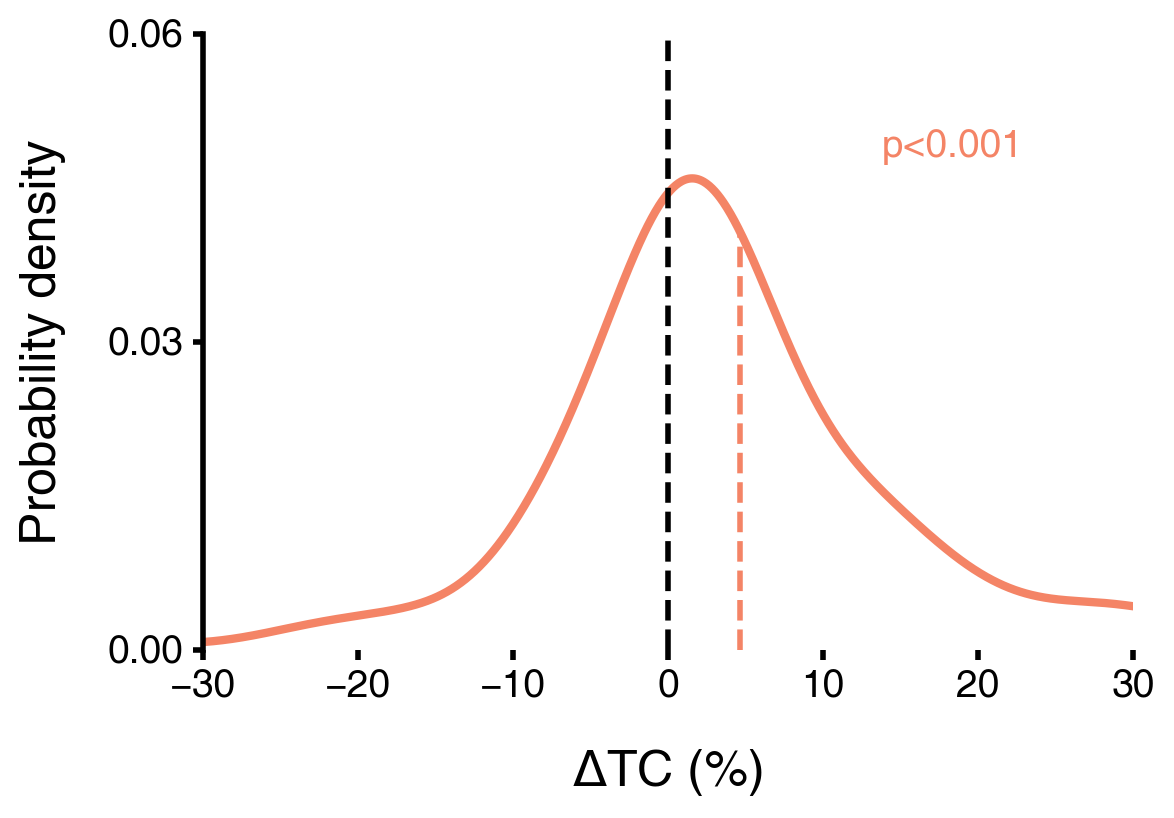

In [31]:
import gloce as gc
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), sharex=False,sharey=False) ##width, height default(8,6)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
plt.rc('font', **font)  # pass in the font dict as kwargs
#pp=[p_delta_LA[1],p_delta_LA[0]]
#pp1=[p_delta_LC[1],p_delta_LC[0]]
cl1 = np.array([(82,160,134),(244,132,102)])
cl2=cl1/255
label=['$\Delta$ TH','$\Delta$ TC']
#colors = ['coral','yellowgreen','green','orange']
#lc3 = ['NF_BB','F_BB','F_NBB','NF_NBB']
#fig, axs=plt.subplots(2,2,sharex=True,sharey=True)

#for i in range(2):
i=1
x=np.linspace(-30,30,1000)
mean=np.nanmean(df_delta[i])
delta_rav=gc.nanravel(df_delta[i])
kenal=gaussian_kde(delta_rav)
z=kenal.evaluate(x)
z_mean=kenal.evaluate(mean)
print(mean,z_mean)
label2=['TH'' {:.2f} ***'.format(mean),'TC'' {:.2f} ***'.format(mean)]
ax.plot(x,z,lw=3,color=cl2[i])
ax.text(0.73,0.89-j*0.09, 'p<0.001'.format(mean), fontsize=14,transform = ax.transAxes,color=cl2[i])
ax.vlines(mean,0,z_mean,lw=2,ls='--',color=cl2[i])
ax.vlines(0,0,0.2,lw=2,ls='--',color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.legend(fontsize=12,loc='upper left',frameon=False)

#ax.text(-0.17,1, '(c)', transform = ax.transAxes,color='black',fontsize=18)
ax.set_ylim(0,0.06)
ax.set_xlim(-30,30)
ax.set_xticks(np.arange(-30,30.01,10))
ax.set_yticks(np.arange(0,0.061,0.03))
ax.set_ylabel('Probability density',labelpad=15)
ax.set_xlabel('$\Delta$TC (%)',labelpad=15)
ax.tick_params(labelsize=14)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
ax.spines['left'].set_linewidth(2)
#rect = ax.patch
#rect.set_facecolor((202/255,233/255,246/255))
#fig.savefig("C:/Users/dess/resistance.png", dpi=750, bbox_inches = 'tight')

## non-increased paired sites(0.25°)

In [14]:
#current shape:(6500,7900)
#0.01deg to 0.5 deg window size=2500 pixels
#6500/50,7900/50...(130,158)
def slide_window_mean(s,dist,res):
    # hold there are non NaN value in every para-arrays
    #s:window size
    #dist:disturb array
    #res:resistance and resilience array
    mean_arr=np.zeros((260,316))
    weight_arr=np.zeros((260,316))
    loc=np.zeros((260,316)) #record the location of supplied sites
    sl=np.ones((25,25))
    for i in range(260):
        #print("sliding", i, "line...")
        for j in range(316):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/625#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
            else:
                mean_arr[i,j]=np.nan#calculate the mean value
                    #loc[i,j]=np.nan
    return mean_arr

dist_pool=[DEAA*mask,DAA*mask]
res_pool=[treeH,tc,dem,slope]
dist_name=['DEAA','DAA']
res_name=['TH','TC','dem','slope']

bb=[]
bb_name=[]
for i in range(2):
    for j in range(4):
        el=[25,dist_pool[i],res_pool[j]]
        bb.append(el)
        bb_name.append('forest-structure_{}_{}_0.25deg_240402.npy'.format(dist_name[i],res_name[j]))
bb_name

['forest-structure_DEAA_TH_0.25deg_240402.npy',
 'forest-structure_DEAA_TC_0.25deg_240402.npy',
 'forest-structure_DEAA_dem_0.25deg_240402.npy',
 'forest-structure_DEAA_slope_0.25deg_240402.npy',
 'forest-structure_DAA_TH_0.25deg_240402.npy',
 'forest-structure_DAA_TC_0.25deg_240402.npy',
 'forest-structure_DAA_dem_0.25deg_240402.npy',
 'forest-structure_DAA_slope_0.25deg_240402.npy']

In [15]:
for i in range(8):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(bb[i][0],bb[i][1],bb[i][2])
    np.save(spei_path+bb_name[i],kk)

执行任务0 (31992)...
执行任务1 (31992)...
执行任务2 (31992)...
执行任务3 (31992)...
执行任务4 (31992)...
执行任务5 (31992)...
执行任务6 (31992)...
执行任务7 (31992)...


## 成对样点求Δ

In [8]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
dem1=np.load(spei_path+'forest-structure_DEAA_dem_0.25deg_240402.npy',allow_pickle=True)
dem2=np.load(spei_path+'forest-structure_DAA_dem_0.25deg_240402.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(spei_path+'forest-structure_DEAA_slope_0.25deg_240402.npy',allow_pickle=True)
slo2=np.load(spei_path+'forest-structure_DAA_slope_0.25deg_240402.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))*dem_differ*slo_differ

In [9]:
res_name=['TH','TC']
delta=[]
for i in range(2):
    f1=np.load(spei_path+'forest-structure_DEAA_{}_0.25deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(spei_path+'forest-structure_DAA_{}_0.25deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ff=f1-f2
    delta.append(ff)
delta[0].shape

(260, 316)

In [10]:
for i in range(2):
    print(res_name[i],"tree count is",np.count_nonzero(~np.isnan(delta[i])))

TH tree count is 552
TC tree count is 577


In [11]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

res_delta=[]
for i in range(2):
    res_delta.append(kill_nan(delta[i]))

res_delta=list(map(list, zip(*res_delta)))#list转置
df_res_delta1=pd.DataFrame(res_delta,columns=['TH','TC'])
df_res_delta1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TH      552 non-null    float64
 1   TC      552 non-null    float64
dtypes: float64(2)
memory usage: 8.8 KB


In [12]:
print(np.std(df_res_delta1['TH']),np.std(df_res_delta1['TC']))
print(np.mean(df_res_delta1['TH']),np.mean(df_res_delta1['TC']))

3.895170722388632 11.878649887874033
1.3557737525012614 3.329564924257389


## Fig

### significants

In [13]:
def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

p_delta1=[]
for i in range(2):
    f1=np.load(spei_path+'forest-structure_DEAA_{}_0.25deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(spei_path+'forest-structure_DAA_{}_0.25deg_240402.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    p_delta1.append(p)
p_delta1

[1.134586071952828e-15, 2.7570412733651083e-08]

In [22]:
df_delta=[df_res_delta1['TH'],df_res_delta1['TC']]

### fig-pdf

4.880286004066467 [0.04273391]


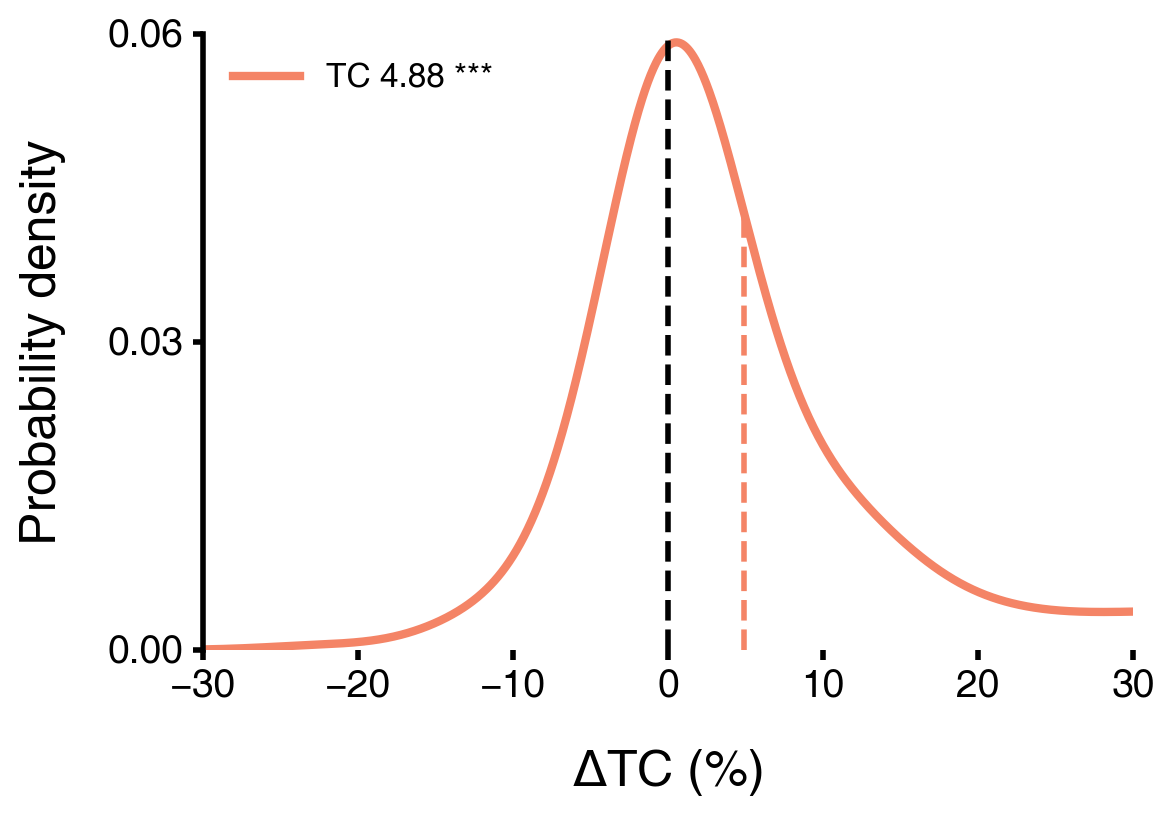

In [27]:
import gloce as gc
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), sharex=False,sharey=False) ##width, height default(8,6)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
plt.rc('font', **font)  # pass in the font dict as kwargs
#pp=[p_delta_LA[1],p_delta_LA[0]]
#pp1=[p_delta_LC[1],p_delta_LC[0]]
cl1 = np.array([(82,160,134),(244,132,102)])
cl2=cl1/255
label=['$\Delta$ TH','$\Delta$ TC']
#colors = ['coral','yellowgreen','green','orange']
#lc3 = ['NF_BB','F_BB','F_NBB','NF_NBB']
#fig, axs=plt.subplots(2,2,sharex=True,sharey=True)

#for i in range(2):
i=1
x=np.linspace(-30,30,1000)
mean=np.nanmean(df_delta[i])
delta_rav=gc.nanravel(df_delta[i])
kenal=gaussian_kde(delta_rav)
z=kenal.evaluate(x)
z_mean=kenal.evaluate(mean)
print(mean,z_mean)
label2=['TH'' {:.2f} ***'.format(mean),'TC'' {:.2f} ***'.format(mean)]
ax.plot(x,z,lw=3,color=cl2[i],label=label2[i])
ax.vlines(mean,0,z_mean,lw=2,ls='--',color=cl2[i])
ax.vlines(0,0,0.2,lw=2,ls='--',color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.legend(fontsize=12,loc='upper left',frameon=False)

#ax.text(-0.17,1, '(c)', transform = ax.transAxes,color='black',fontsize=18)
ax.set_ylim(0,0.06)
ax.set_xlim(-30,30)
ax.set_xticks(np.arange(-30,30.01,10))
ax.set_yticks(np.arange(0,0.061,0.03))
ax.set_ylabel('Probability density',labelpad=15)
ax.set_xlabel('$\Delta$TC (%)',labelpad=15)
ax.tick_params(labelsize=14)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
ax.spines['left'].set_linewidth(2)
#rect = ax.patch
#rect.set_facecolor((202/255,233/255,246/255))
#fig.savefig("C:/Users/dess/resistance.png", dpi=750, bbox_inches = 'tight')

# low_SPEI(2°)

In [24]:
#low SPEI data see section 2.1 of py_v4_03c_SI_delta_resistance_pdf_240507.ipynb
spei05='D:/Elephant_disturb/SPEI/'
drought=read_img(spei05+'SPEI_drought05_sub_001_afr.tif')[0]
ele_path='//weili/User2/mxsun/CESS_230818/elephant_active_area/IUCN/'
ele=read_img(ele_path+'fireCCI_eleIUCN20_LA-LCextant_mask001_230523.tif')[0]
ele[ele>0]=1
DEAA=drought*ele
DAA=drought-DEAA
DEAA[DEAA==0]=np.nan
DAA[DAA==0]=np.nan

## slide window

In [42]:
#current shape:(6500,7900)
#0.01deg to 0.5 deg window size=2500 pixels
#6500/50,7900/50...(130,158)
def slide_window_mean(s,dist,res):
    # hold there are non NaN value in every para-arrays
    #s:window size
    #dist:disturb array
    #res:resistance and resilience array
    mean_arr=np.zeros((32,39))
    weight_arr=np.zeros((32,39))
    loc=np.zeros((32,39)) #record the location of supplied sites
    sl=np.ones((200,200))
    for i in range(32):
        #print("sliding", i, "line...")
        for j in range(39):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/40000#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
            else:
                bloc_dist_a=[] #should be 8 nums [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                res_dist_a=[] #should be 8 nums
                res_mask_pool=[]
                weight_pool=[]
                for m in [-1,1]:
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    bloc_dist_a.append(dist[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    res_dist_a.append(res[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                bloc_dist_a.append(dist[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                bloc_dist_a.append(dist[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                res_dist_a.append(res[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                res_dist_a.append(res[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                #the smooth order of a 9 value array is [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                for n in range(len(bloc_dist_a)): #the length is 8
                    res_mask_pool.append(np.multiply(bloc_dist_a[n],res_dist_a[n]))
                    weight_pool.append(np.count_nonzero(~np.isnan(res_mask_pool[n]))/40000)#calculate the weight
                key=np.argmax(weight_pool) 
                # Key used to loc the supplied direction, the key-value consistience with [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                if weight_pool[key] > 0.05:
                    weight_arr[i,j]=weight_pool[key]
                    dt1=np.where(res_mask_pool[key]!=np.nan,res_mask_pool[key],np.nan)
                    mean_arr[i,j]=np.nanmean(dt1)#calculate the mean value
                    #loc[i,j]=key+1
                else:
                    mean_arr[i,j]=np.nan#calculate the mean value
                    #loc[i,j]=np.nan
    return mean_arr

dist_pool=[DEAA*mask,DAA*mask]
res_pool=[treeH,tc,dem,slope]
dist_name=['DEAA','DAA']
res_name=['TH','TC','dem','slope']

bb=[]
bb_name=[]
for i in range(2):
    for j in range(4):
        el=[200,dist_pool[i],res_pool[j]]
        bb.append(el)
        bb_name.append('forest-structure_low-SPEI_{}_{}_1deg_240402.npy'.format(dist_name[i],res_name[j]))
bb_name

['forest-structure_low-SPEI_DEAA_TH_1deg_240402.npy',
 'forest-structure_low-SPEI_DEAA_TC_1deg_240402.npy',
 'forest-structure_low-SPEI_DEAA_dem_1deg_240402.npy',
 'forest-structure_low-SPEI_DEAA_slope_1deg_240402.npy',
 'forest-structure_low-SPEI_DAA_TH_1deg_240402.npy',
 'forest-structure_low-SPEI_DAA_TC_1deg_240402.npy',
 'forest-structure_low-SPEI_DAA_dem_1deg_240402.npy',
 'forest-structure_low-SPEI_DAA_slope_1deg_240402.npy']

In [43]:
for i in range(8):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(bb[i][0],bb[i][1],bb[i][2])
    np.save(spei_path+bb_name[i],kk)

执行任务0 (31992)...
执行任务1 (31992)...
执行任务2 (31992)...
执行任务3 (31992)...
执行任务4 (31992)...
执行任务5 (31992)...
执行任务6 (31992)...
执行任务7 (31992)...


C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## 成对样点求Δ

In [14]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
dem1=np.load(spei_path+'forest-structure_low-SPEI_DEAA_dem_1deg_240402.npy',allow_pickle=True)
dem2=np.load(spei_path+'forest-structure_low-SPEI_DAA_dem_1deg_240402.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(spei_path+'forest-structure_low-SPEI_DEAA_slope_1deg_240402.npy',allow_pickle=True)
slo2=np.load(spei_path+'forest-structure_low-SPEI_DAA_slope_1deg_240402.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((32,39))*dem_differ*slo_differ

In [15]:
res_name=['TH','TC']
delta=[]
for i in range(2):
    f1=np.load(spei_path+'forest-structure_low-SPEI_DEAA_{}_1deg_240402.npy'.format(res_name[i]),allow_pickle=True)#*dd_mask
    f2=np.load(spei_path+'forest-structure_low-SPEI_DAA_{}_1deg_240402.npy'.format(res_name[i]),allow_pickle=True)#*dd_mask
    ff=f1-f2
    delta.append(ff)
delta[0].shape

(32, 39)

In [16]:
for i in range(2):
    print(res_name[i],"res count is",np.count_nonzero(~np.isnan(delta[i])))

TH res count is 169
TC res count is 196


In [17]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

res_delta=[]
for i in range(2):
    res_delta.append(kill_nan(delta[i]))

res_delta=list(map(list, zip(*res_delta)))#list转置
df_res_delta2=pd.DataFrame(res_delta,columns=['TH','TC'])
df_res_delta2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TH      169 non-null    float64
 1   TC      169 non-null    float64
dtypes: float64(2)
memory usage: 2.8 KB


In [18]:
print(np.std(df_res_delta2['TH']),np.std(df_res_delta2['TC']))
print(np.mean(df_res_delta2['TH']),np.mean(df_res_delta2['TC']))

4.5029934716877085 15.76384778295875
1.9734780278784283 4.867415588988355


## Fig

### significants

In [19]:
def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

p_delta2=[]
for i in range(2):
    f1=np.load(spei_path+'forest-structure_low-SPEI_DEAA_{}_1deg_240402.npy'.format(res_name[i]),allow_pickle=True)#*dd_mask
    f2=np.load(spei_path+'forest-structure_low-SPEI_DAA_{}_1deg_240402.npy'.format(res_name[i]),allow_pickle=True)#*dd_mask
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    p_delta2.append(p)
p_delta2

[1.0509150961444134e-07, 0.006905015814885998]

### fig-pdf

In [42]:
df_delta=[df_res_delta2['TH'],df_res_delta2['TC']]

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

5.855333047754624 [0.0379918]


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

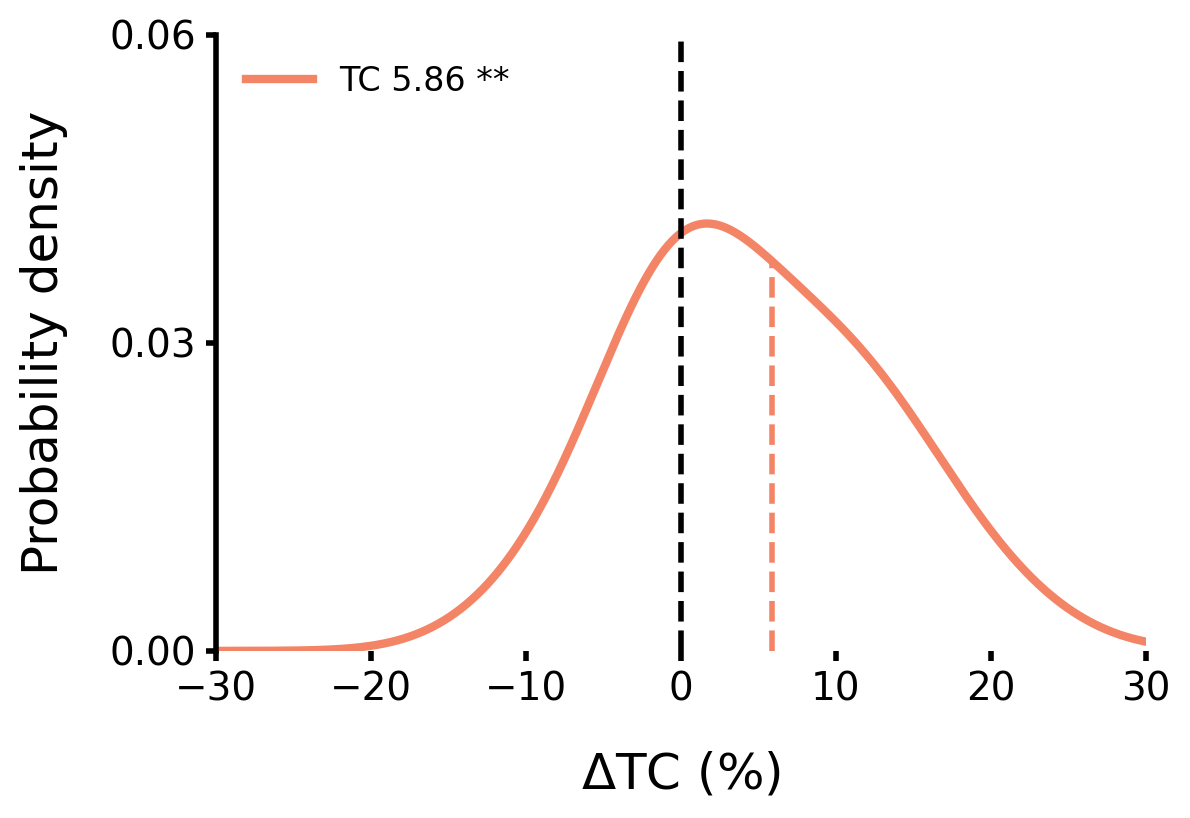

In [58]:
import gloce as gc
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), sharex=False,sharey=False) ##width, height default(8,6)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
plt.rc('font', **font)  # pass in the font dict as kwargs
#pp=[p_delta_LA[1],p_delta_LA[0]]
#pp1=[p_delta_LC[1],p_delta_LC[0]]
cl1 = np.array([(82,160,134),(244,132,102)])
cl2=cl1/255
label=['$\Delta$ TH','$\Delta$ TC']
#colors = ['coral','yellowgreen','green','orange']
#lc3 = ['NF_BB','F_BB','F_NBB','NF_NBB']
#fig, axs=plt.subplots(2,2,sharex=True,sharey=True)

#for i in range(2):
i=1
x=np.linspace(-30,30,1000)
mean=np.nanmean(df_delta[i])
delta_rav=gc.nanravel(df_delta[i])
kenal=gaussian_kde(delta_rav)
z=kenal.evaluate(x)
z_mean=kenal.evaluate(mean)
print(mean,z_mean)
label2=['TH'' {:.2f} ***'.format(mean),'TC'' {:.2f} **'.format(mean)]
ax.plot(x,z,lw=3,color=cl2[i],label=label2[i])
ax.vlines(mean,0,z_mean,lw=2,ls='--',color=cl2[i])
ax.vlines(0,0,0.2,lw=2,ls='--',color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.legend(fontsize=12,loc='upper left',frameon=False)

#ax.text(-0.17,1, '(c)', transform = ax.transAxes,color='black',fontsize=18)
ax.set_ylim(0,0.06)
ax.set_xlim(-30,30)
ax.set_xticks(np.arange(-30,30.01,10))
ax.set_yticks(np.arange(0,0.061,0.03))
ax.set_ylabel('Probability density',labelpad=15)
ax.set_xlabel('$\Delta$TC (%)',labelpad=15)
ax.tick_params(labelsize=14)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
ax.spines['left'].set_linewidth(2)
#rect = ax.patch
#rect.set_facecolor((202/255,233/255,246/255))
#fig.savefig("C:/Users/dess/resistance.png", dpi=750, bbox_inches = 'tight')

# combine map

In [20]:
df_res_delta2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TH      169 non-null    float64
 1   TC      169 non-null    float64
dtypes: float64(2)
memory usage: 2.8 KB


In [21]:
len(df_res_delta['TH']),len(df_res_delta1['TH']),len(df_res_delta2['TH'])

(1207, 552, 169)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


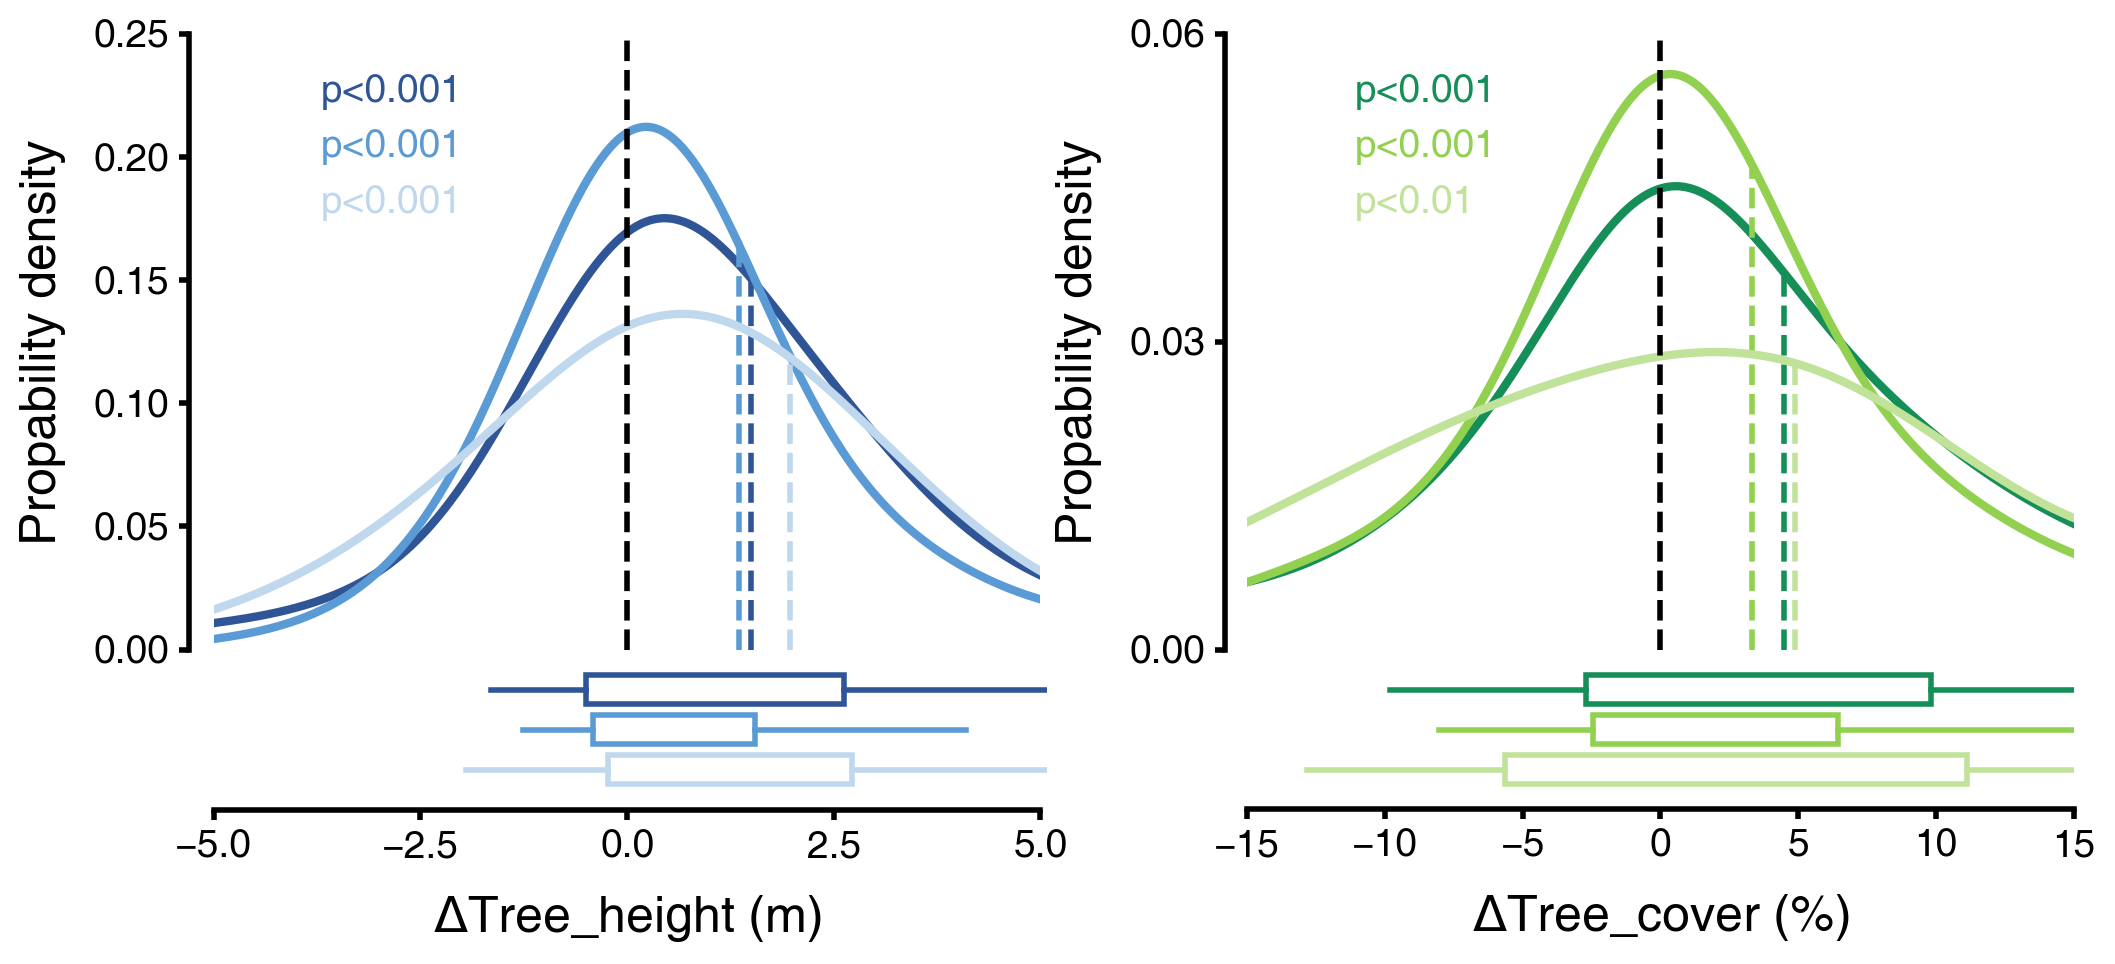

In [23]:
#['treeH','tc_planet']
#['treeH','th_Lange','tc_planet','tc_Hansen10','Bio','et','lai']
data_th=[df_res_delta['TH'],df_res_delta1['TH'],df_res_delta2['TH']]
data_pp_th=[p_delta[0],p_delta1[0],p_delta2[0]]
data_tc=[df_res_delta['TC'],df_res_delta1['TC'],df_res_delta2['TC']]
data_pp_tc=[p_delta[1],p_delta1[1],p_delta2[1]]

data=[data_th,data_tc]
pp=[data_pp_th,data_pp_tc]

import gloce as gc
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(12,4)) ##width, height default(8,6)
plt.subplots_adjust(wspace=0.25,hspace=0.02)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 18}
plt.rc('font', **font)  # pass in the font dict as kwargs
cl1 = np.array([(47,85,151),(91,155,213),(192,216,238)])
cl2 = np.array([(22,142,88),(146,208,80),(192,227,153)])
cl=[cl1/255,cl2/255]
#cl=['C0','salmon']
#colors = ['coral','yellowgreen','green','orange']
#lc3 = ['NF_BB','F_BB','F_NBB','NF_NBB']
#fig, axs=plt.subplots(2,2,sharex=True,sharey=True)
label1=['TH from Potapov $\mathit{et}$ $\mathit{al.}$','TH from Lang $\mathit{et}$ $\mathit{al.}$']
label2=['TC from Reiner $\mathit{et}$ $\mathit{al.}$','TC from Hansen $\mathit{et}$ $\mathit{al.}$']
label=[label1,label2]
tx=['(m)','(%)']
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    for j in range(3):
        x=np.linspace(-15,15,1000)
        mean=np.nanmean(data[i][j])
        delta_rav=gc.nanravel(data[i][j])
        kenal=gaussian_kde(delta_rav)
        z=kenal.evaluate(x)
        z_mean=kenal.evaluate(mean)
        ax.plot(x,z,lw=3,color=cl[i][j])
        ax.vlines(mean,0,z_mean,lw=2,ls='--',color=cl[i][j])
        if pp[i][j]<0.001:
            #ax.text(0.73,0.89-j*0.09, '{:.2f} ***'.format(mean), fontsize=16,transform = ax.transAxes,color=cl[i][j])
            ax.text(0.13,0.89-j*0.09, 'p<0.001', fontsize=14,transform = ax.transAxes,color=cl[i][j])
        elif pp[i][j]<0.01:
            ax.text(0.13,0.89-j*0.09, 'p<0.01', fontsize=14,transform = ax.transAxes,color=cl[i][j])
        elif pp[i][j]<0.05:
            ax.text(0.13,0.89-j*0.09,  'p<0.05'.format(mean), fontsize=14,transform = ax.transAxes,color=cl[i][j])
        else:
            ax.text(0.13,0.89-j*0.09,  'p={:.2f}'.format(pp[i][j]), fontsize=14,transform = ax.transAxes,color=cl[i][j])
    if i ==0:
        ax.vlines(0,0,0.25,lw=2,ls='--',color='black')
        ax.set_ylim(0,0.25)
        ax.set_yticks(np.arange(0,0.251,0.05))
        ax.set_xlim(-5,5)
        ax.set_xticks(np.arange(-5,5.1,2.5))
        ax=plt.gca()
        ax.yaxis.set_ticks_position('left')
        ax.spines['left'].set_position(('data',-5.3))
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('data',-0.065))
        ax.set_xlabel('$\Delta$Tree_height (m)',labelpad=10)
    else:
        ax.vlines(0,0,0.06,lw=2,ls='--',color='black')
        ax.set_ylim(0,0.06)
        ax.set_yticks(np.arange(0,0.061,0.03))
        ax.set_xlim(-15,15)
        ax.set_xticks(np.arange(-15,15.1,5))
        ax=plt.gca()
        ax.yaxis.set_ticks_position('left')
        ax.spines['left'].set_position(('data',-15.8))
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('data',-0.0155))
        ax.set_xlabel('$\Delta$Tree_cover (%)',labelpad=10)
    ax.legend(fontsize=14,loc='upper left',frameon=False,handlelength=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.set_xlim(-2,2)
    #ax.set_xticks(np.arange(-2,2,0.5))
    ax.set_ylabel('Propability density',labelpad=10)
    
    ax.xaxis.label.set_size(18)
    ax.xaxis.set_tick_params(width=2)

    ax.tick_params(labelsize=14)
    ax.yaxis.label.set_size(18)
    ax.yaxis.set_tick_params(width=2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    
    for j in range(3):
        if i ==0:
            if j ==0:
                ax1=fig.add_axes([0.122,-0,0.35,0.12])#左，底，宽，高
            elif j ==1:
                ax1=fig.add_axes([0.122,-0.05,0.35,0.12])#左，底，宽，高
            else:
                ax1=fig.add_axes([0.122,-0.1,0.35,0.12])#左，底，宽，高
            ax1.set_xlim(-5,5)
            ax1.set_xticks(np.arange(-5,5,2.5))
        if i ==1:
            if j==0:
                ax1=fig.add_axes([0.55,-0,0.35,0.12])#左，底，宽，高
            elif j==1:
                ax1=fig.add_axes([0.55,-0.05,0.35,0.12])#左，底，宽，高
            else:
                ax1=fig.add_axes([0.55,-0.1,0.35,0.12])#左，底，宽，高
            ax1.set_xlim(-15,15)
            ax1.set_xticks(np.arange(-15,15,5))
        ax1.axis('off')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        ax1.tick_params(bottom=False,top=False, left=False, right=False)#隐藏刻度线
        #ax.spines['bottom'].set_visible(False)
        bplot=ax1.boxplot(data[i][j],
                          vert=False,
                          whis=(10,90),                
                          widths=0.3,
                          patch_artist=True,
                          showmeans=False,
                          meanprops = {'marker':'o','markerfacecolor':cl[i][j],"markeredgecolor":cl[i][j],"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                          medianprops={'linewidth':'0.5',"color":cl[i][j],"alpha":0},
                          boxprops={"facecolor": 'none', "edgecolor": cl[i][j],"linewidth":2,"alpha":1},
                          capprops=None,
                          whiskerprops={'linewidth':'2','color':cl[i][j]},
                          showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示；
                          showfliers = False,
                          flierprops = {'marker':'+','markersize':'3','markeredgecolor':cl[i][j],'color':cl[i][j]})

#rect.set_facecolor((202/255,233/255,246/255))
#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig2_c-d.tif", dpi=600, bbox_inches = 'tight')